# Cross section computation using the Discrete Integral Transform (DIT) for rapid spectral synthesis

We demonstarte the Discrete Integral Transform (DIT) method proposed by D.C.M van den Bekerom and E.Pannier. DIT takes advantage especially for the case that the number of the molecular line is large (typically > 10,000). We here compare the results by DIT with the direct computation (LPF).  



In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here, we use FP64, but if you want you can use FP32 (but slightly large errors):

In [2]:
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.utils.grids import wavenumber_grid
from exojax.spec import api

# Setting wavenumber bins and loading HITRAN database
nus, wav, resolution = wavenumber_grid(1900.0, 2300.0, 350000, unit="cm-1", xsmode="dit")
mdbCO = api.MdbHitran('CO', nus, gpu_transfer=True)

# set T, P and partition function
Mmol = 28.01  # molecular weight
Tfix = 1000.0  # we assume T=1000K
Pfix = 1.e-3  # we compute P=1.e-3 bar
Ppart = Pfix  #partial pressure of CO. here we assume a 100% CO atmosphere.
qt = mdbCO.qr_interp(0,Tfix)

# compute Sij, gamma_L, sigmaD
Sij = SijT(Tfix, mdbCO.logsij0, mdbCO.nu_lines, mdbCO.elower, qt)
gammaL = gamma_hitran(Pfix,Tfix, Ppart, mdbCO.n_air, \
                      mdbCO.gamma_air, mdbCO.gamma_self) \
+ gamma_natural(mdbCO.A)
sigmaD = doppler_sigma(mdbCO.nu_lines, Tfix, Mmol)


xsmode assumes ESLIN in wavenumber space: mode=dit


DIT uses a grid of sigmaD, gammaL, and wavenumber. set_ditgrid.ditgrid_log_interval makes a 1D grid for sigmaD and gamma.

In [4]:
from exojax.spec.set_ditgrid import ditgrid_log_interval
sigmaD_grid=ditgrid_log_interval(sigmaD)
gammaL_grid=ditgrid_log_interval(gammaL)

# we can change the resolution using res option
#sigmaD_grid=set_ditgrid(sigmaD,res=0.1)
#gammaL_grid=set_ditgrid(gammaL,res=0.1)

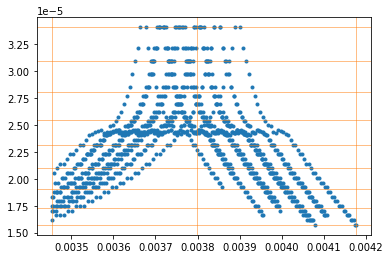

In [5]:
#show the grids
plt.plot(sigmaD,gammaL,".")
for i in sigmaD_grid:
    plt.axvline(i,lw=1,alpha=0.5,color="C1")
for i in gammaL_grid:
    plt.axhline(i,lw=1,alpha=0.5,color="C1")

We need to precompute the contribution for wavenumber. Also, pmarray is needed. These can be computed using init_dit. 

In [6]:
from exojax.spec import initspec 
cnu,indexnu,pmarray=initspec.init_dit(mdbCO.nu_lines,nus)

Then, let's compute a cross section!

In [7]:
from exojax.spec.dit import xsvector
xs=xsvector(cnu,indexnu,pmarray,sigmaD,gammaL,Sij,nus,sigmaD_grid,gammaL_grid)

Also, we here try the direct computation using LPF for the comparison purpose

In [8]:
from exojax.spec.lpf import auto_xsection
xsv=auto_xsection(nus,mdbCO.nu_lines,sigmaD,gammaL,Sij,memory_size=30) 

100%|██████████| 56/56 [00:08<00:00,  6.29it/s]


The difference is <~ 1%.

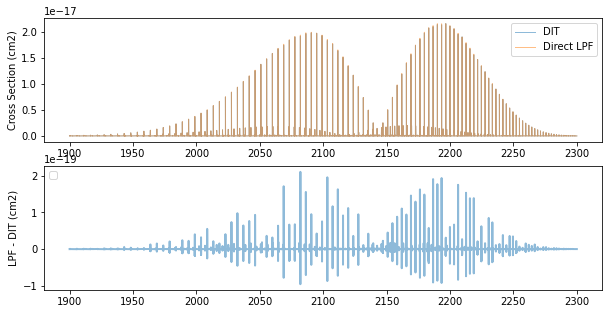

In [9]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(211)
plt.plot(nus, xs, lw=1, alpha=0.5, label="DIT")
plt.plot(nus, xsv, lw=1, alpha=0.5, label="Direct LPF")
plt.legend(loc="upper right")
plt.ylabel("Cross Section (cm2)")
ax = fig.add_subplot(212)
#plt.plot(nus,xsv-xs,lw=2,alpha=0.5,label="precomputed")
plt.plot(nus, xsv - xs, lw=2, alpha=0.5)
plt.ylabel("LPF - DIT (cm2)")
plt.legend(loc="upper left")
plt.show()